In [1]:
cd ../

c:\Users\eduar\Documents\usp\AMST\ml_timeseries_usp


In [67]:
from utils import (
    read_all_csv_files,
    correcting_dtypes,
    stocks_removing_negatives,
    remove_materials_no_sales,
    plot_time_series_by_products,
    plot_products_materials,
    plot_produtos_in_cds,
    plot_time_series_cds_products_by_stores,
    plot_time_series_cds_products_by_store_size,
    plot_time_series_cds_products_by_store_weather,
    plot_time_series_cds_products_by_store_profile,
    plot_time_series_cds_products_store_region,
    violin_plot_material_store_sales,
    hierarchical_aggregation,
    remove_time_series_min_length
    )
import pandas as pd
import seaborn as sns
from statsforecast import StatsForecast
from statsforecast.models import MSTL,AutoETS,AutoARIMA
from hierarchicalforecast.methods import BottomUp
from statsmodels.graphics.tsaplots import plot_acf
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import evaluate
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace
from hierarchicalforecast.utils import aggregate, HierarchicalPlot
from utilsforecast.losses import rmse, mae, smape, mase, scaled_crps, mqloss
from functools import partial

In [189]:
#data preparation
df = read_all_csv_files()
df = correcting_dtypes(df)
df = stocks_removing_negatives(df)
df = remove_materials_no_sales(df)
df = remove_time_series_min_length(df, min_length=24)

In [190]:
spec = [
        ['total'],
        ['total','centro_distribuicao'],
        ['total','centro_distribuicao','regiao_loja'],
        ['total','centro_distribuicao','regiao_loja','clima_loja'],
        ['total','centro_distribuicao','regiao_loja','clima_loja','loja'],
        ['total','centro_distribuicao','regiao_loja','clima_loja','loja','produto'],
        ['total','centro_distribuicao','regiao_loja','clima_loja','loja','produto','material'],
        ['total','centro_distribuicao','regiao_loja','clima_loja','loja','produto','material','sku']
]

Y_df, S_df, tags = hierarchical_aggregation(df, spec, columns = ['centro_distribuicao','regiao_loja','clima_loja','loja','produto','material','sku','mes','venda_unidades'], ds='mes', y='venda_unidades')

Níveis criados:
total: 1 séries
total/centro_distribuicao: 3 séries
total/centro_distribuicao/regiao_loja: 8 séries
total/centro_distribuicao/regiao_loja/clima_loja: 13 séries
total/centro_distribuicao/regiao_loja/clima_loja/loja: 333 séries
total/centro_distribuicao/regiao_loja/clima_loja/loja/produto: 665 séries
total/centro_distribuicao/regiao_loja/clima_loja/loja/produto/material: 2325 séries
total/centro_distribuicao/regiao_loja/clima_loja/loja/produto/material/sku: 11266 séries


In [191]:
Y_test_df  = Y_df.groupby('unique_id').tail(6)
Y_train_df = Y_df.drop(Y_test_df.index)

In [192]:
sf = StatsForecast(models=[AutoARIMA(season_length=12)], freq="MS", n_jobs=-1)

In [193]:
Y_hat_df = sf.forecast(h=6, df=Y_train_df, fitted=True)
Y_fitted_df = sf.forecast_fitted_values()

In [194]:
# 4. Specify the reconcilers
reconcilers = [BottomUp(),TopDown(method='forecast_proportions'), MinTrace(method="ols"), MinTrace(method="mint_shrink")]

# 5. Reconcile the forecasts
hrec = HierarchicalReconciliation(reconcilers=reconcilers)

Y_rec_df = hrec.reconcile(Y_hat_df=Y_hat_df, Y_df=Y_fitted_df, S_df=S_df, tags=tags)

In [180]:
from utilsforecast.plotting import plot_series

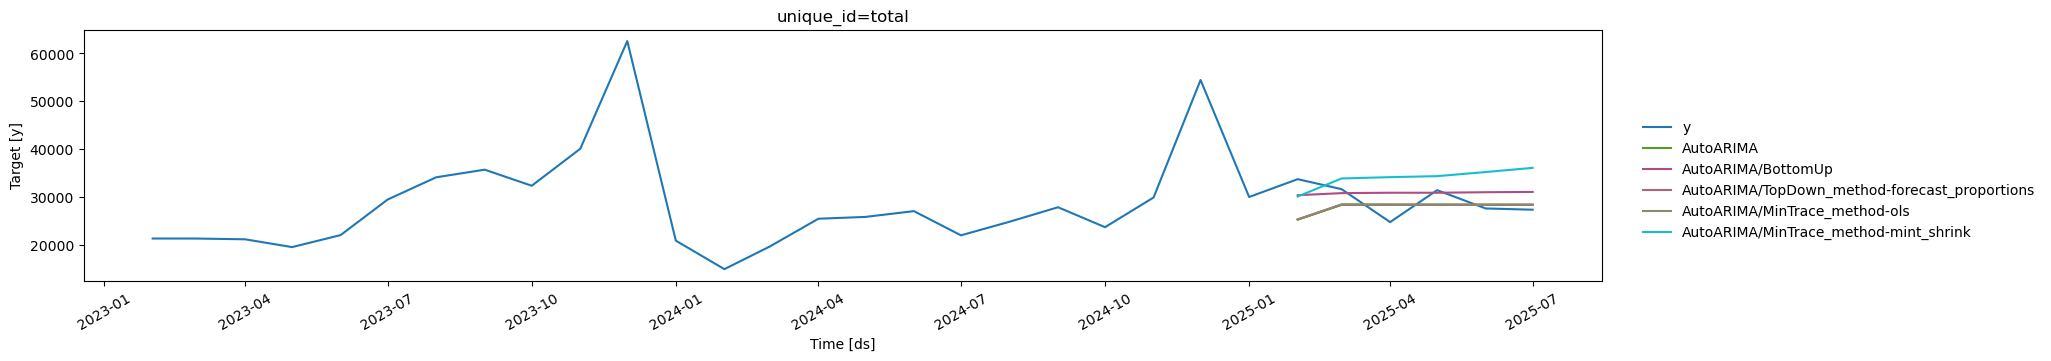

In [207]:
plot_aggs = list(tags["total"])

fig = plot_series(
    df=Y_df.query("unique_id in @plot_aggs"),
    forecasts_df=Y_rec_df.query("unique_id in @plot_aggs"),
    plot_random=False,
)
fig.legends = []
handles, labels = fig.axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.02, 0.5),
           borderaxespad=0,
           frameon=False)
fig

In [196]:
df = Y_rec_df.merge(Y_test_df, on=['unique_id', 'ds'], how='inner')

evaluate(df=df, metrics=[smape],
                   tags=tags)

,level,metric,AutoARIMA,AutoARIMA/BottomUp,AutoARIMA/TopDown_method-forecast_proportions,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-mint_shrink
0,total,smape,0.058243,0.051043,0.058243,0.058020,0.092386
1,total/centro_distribuicao,smape,0.107055,0.098622,0.107423,0.103665,0.112154
2,total/centro_distribuicao/regiao_loja,smape,0.118297,0.116900,0.122974,0.199944,0.117888
3,total/centro_distribuicao/regiao_loja/clima_loja,smape,0.108724,0.110116,0.113261,0.162459,0.123611
4,total/centro_distribuicao/regiao_loja/clima_lo...,smape,0.159310,0.151849,0.165165,0.166171,0.174827
5,total/centro_distribuicao/regiao_loja/clima_lo...,smape,0.233493,0.230107,0.238175,0.276249,0.262049
6,total/centro_distribuicao/regiao_loja/clima_lo...,smape,0.315006,0.312866,0.324447,0.354511,0.371548
7,total/centro_distribuicao/regiao_loja/clima_lo...,smape,0.490923,0.490923,0.500707,0.565616,0.578511
8,Overall,smape,0.443013,0.442347,0.452410,0.509073,0.521200


In [151]:
Y_rec_df

,unique_id,ds,AutoARIMA,AutoARIMA/BottomUp,AutoARIMA/TopDown_method-forecast_proportions,AutoARIMA/MinTrace_method-ols,AutoARIMA/MinTrace_method-mint_shrink
0,total,2025-02-01,25259.883952,26703.961626,25259.883952,25294.608709,26437.444856
1,total,2025-03-01,28369.601777,29205.929621,28369.601777,28444.180529,29078.729157
2,total,2025-04-01,28369.601777,28944.670718,28369.601777,28419.616656,28853.955074
3,total,2025-05-01,28369.601777,28776.578592,28369.601777,28403.897618,28709.816450
4,total,2025-06-01,28369.601777,28667.969508,28369.601777,28393.824177,28617.151962
...,...,...,...,...,...,...,...
145,total/CD3/NORTE/3,2025-03-01,711.208333,711.208333,711.396456,686.348749,709.747727
146,total/CD3/NORTE/3,2025-04-01,711.208333,711.208333,711.396456,694.536707,710.215825
147,total/CD3/NORTE/3,2025-05-01,711.208333,711.208333,711.396456,699.776386,710.516237
148,total/CD3/NORTE/3,2025-06-01,711.208333,711.208333,711.396456,703.134200,710.709602


In [73]:
Y_test_df

,unique_id,ds,y
23,total,2025-01-01,29996.0
24,total,2025-02-01,33718.0
25,total,2025-03-01,31631.0
26,total,2025-04-01,24745.0
27,total,2025-05-01,31421.0
...,...,...,...
745,total/CD3/NORTE/3,2025-03-01,467.0
746,total/CD3/NORTE/3,2025-04-01,498.0
747,total/CD3/NORTE/3,2025-05-01,669.0
748,total/CD3/NORTE/3,2025-06-01,797.0
